![DaQuiri Logo](daquirilogo.png)

DAMLAS 4 - MSP                                                                                                                 
Team: Rahul Biswas, Vicki Seely & Scott Zuehlke                                                                                           
*&copy; 2016*

__Executive Summary__

Without accurate and effective Data Quality processes, the foundation of any analysis has the potential to be compromised. As the volume and sources of data explode, the role of automated Data Quality becomes even more important. While obvious outliers are easy to detect, flag and remediate, some inaccurate data points may fall within established tolerances. Due to the complexity of the data it’s challenging to automate the process, often requiring manual effort to complete the checks.

[about 125 words to go]

This notebook uses Python, DataFrames, and Oozie workflows to build a process to....

The notebook is organized as follows:

1.	**Introduction** 
2.	**Data**
3.	**ETL**
4.	**Feature Engineering**
5.	**Modeling, Evaluation, and Tuning**
6.	**Results (and systems used)**
7.	**Next Steps**
8.	**Resources/References**
9.	**Appendix**



## Table of Contents <a name="TOC"></a> 

1.  [Introduction](#1)
2.  [Data](#2)
    1.  [Initial Extract From Hadoop](#2.A)
    2.  [Data Profile](#2.B)
    3.  [Target Variables](#2.C)
    4.  [EDA](#2.C)


3.  [ETL](#3)
4.  [Feature Engineering](#4)
5.  [Modeling, Evaluation & Tuning](#5)
6.  [Results / Systems Used](#6)
7.  [Next Steps](#7)
8.  [Resources / References](#8)
9.  [Appendix](#9)

## 1.  Introduction <a name="1"></a>
[Back to Table of Contents](#TOC)

[Blurb about Scott's initial model / why new model needed / changes to process]

DaQuiri’s goal is to minimize the need for manual intervention in the Data Quality process by leveraging machine learning capabilities on BigRed. There is an existing implementation of DaQuiri used to evaluate e-commerce data but it is not scalable to Hadoop. The scalable solution will evaluate production data at regular intervals, leverage a variety of regression approaches and rely on an automated model evaluator to select a champion model. New data records will be evaluated against this model to determine whether it is within an acceptable prediction interval. Effectiveness of this process will be measured through the number of false positives and overall detection accuracy. Another consideration will be processing time within an acceptable SLA.

## 2.  Data <a name="2"></a>
[Back to Table of Contents](#TOC)

The primary data source for this project is Firefly, an in-house digital data collection/real-time streaming platform which, over time, will replace the archived data generated by Adobe’s SiteCatalyst product. 

<a style='bold'>include data dictionary here</a>

### 2.A  Initial Data Extract From Hadoop <a name="2.A"></a>
[Back to Table of Contents](#TOC)

Categorical variables were transformed in the process in order to aggregate the data at the desired time interval.

### 2.B Data Profiling <a name="2.B"></a>
[Back to Table of Contents](#TOC)

In [1]:
import os
import sys
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

spark_path = "C:/opt/spark"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.9-src.zip")

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import SQLContext

sc = SparkContext("local", "test")
sqlContext = SQLContext(sc)

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices, ModelDesc
from sklearn import datasets, svm

df = pd.read_csv("all_data.csv",parse_dates=[0]) 
df['event_min'] = df['event_min'].map({1:14, 2:29, 3:44, 4:59})
df['event_ts'] = df['event_dt'].astype(str)+' '+df['event_hr'].astype(str)+':'+df['event_min'].astype(str)+':59.999999'
df['event_ts'] = pd.to_datetime(df['event_ts'])
cols = df.columns.tolist()
cols = ['event_ts']  + [col for col in df if col != 'event_ts']
df = df[cols]

In [2]:
df.dtypes

event_ts              datetime64[ns]
event_dt              datetime64[ns]
event_hr                       int64
event_min                      int64
unq_visitors                   int64
unq_ip                         int64
cookie_disabl_true             int64
sign_in_rem                    int64
sign_in_no                     int64
sign_in_unk                    int64
windows_os                     int64
iphone_os                      int64
mac_os                         int64
ipad_os                        int64
android_os                     int64
mweb_cnt                       int64
wkly_ad_cnt                    int64
prod_dtl_cnt                   int64
pgvw_cnt                       int64
srch_rslt_cnt                  int64
homepg_cnt                     int64
shp_crt_cnt                    int64
crt_ovrly_cnt                  int64
lvl1_cnt                       int64
lvl2_cnt                       int64
lvl3_cnt                       int64
lvl4_cnt                       int64
p

### 2.C  Target Variables <a name="2.C"></a>
[Back to Table of Contents](#TOC)

For this MVP ('Minimum Viable Product'), we identified three metrics as Target Variables:
1. Demand Sales - all product sales that have gone through the check-out process, but have not yet been picked up or shipped.
2. Unique Visitors - the number of uniquely identified visitors to visit Target.com within the data collection period.
3. Event Count - the number of actions taken by a visitor to Target.com within the data collection period.

In [3]:
u = np.asarray(df['unq_visitors'])
e = np.asarray(df['event_cnt'])
d = np.asarray(df['demand_sales'])
UV = Series(u, index=df['event_ts'])
EC = Series(e, index=df['event_ts'])
DS = Series(d, index=df['event_ts'])

count      7392.000000
mean      60341.361472
std       29800.891845
min         151.000000
25%       32039.500000
50%       67041.000000
75%       84675.000000
max      137710.000000
Name: unq_visitors, dtype: float64

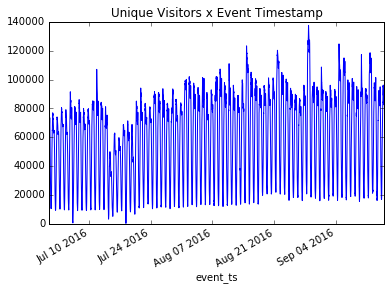

In [4]:
UV.plot(title="Unique Visitors x Event Timestamp")
df['unq_visitors'].describe()

count    7.392000e+03
mean     6.756487e+05
std      3.602113e+05
min      4.660000e+02
25%      3.515280e+05
50%      7.218910e+05
75%      9.346978e+05
max      1.897849e+06
Name: event_cnt, dtype: float64

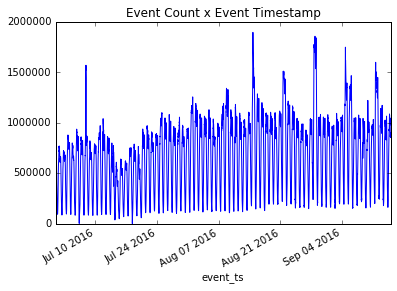

In [5]:
EC.plot(title="Event Count x Event Timestamp")
df['event_cnt'].describe()

count      7392.000000
mean     140326.324517
std       92888.822783
min           0.000000
25%       58240.377515
50%      153778.410450
75%      199346.042625
max      845084.210300
Name: demand_sales, dtype: float64

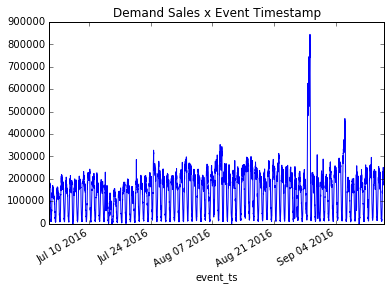

In [6]:
DS.plot(title="Demand Sales x Event Timestamp")
df['demand_sales'].describe()

### 2.D  EDA <a name="2.D"></a>
[Back to Table of Contents](#TOC)

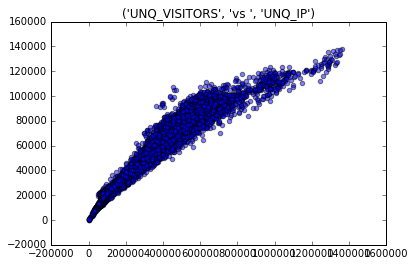

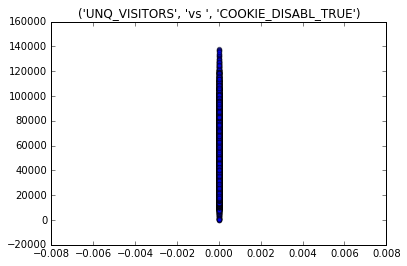

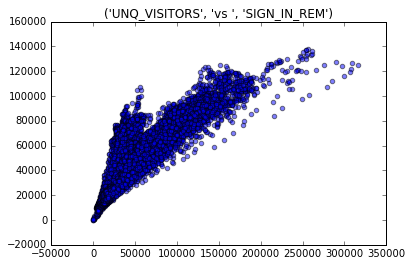

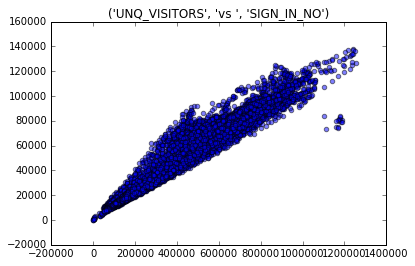

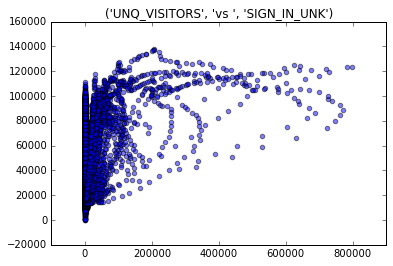

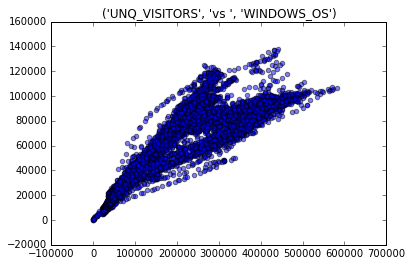

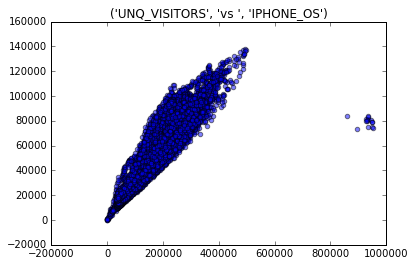

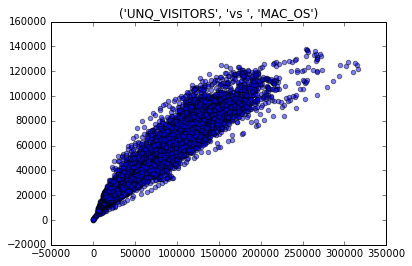

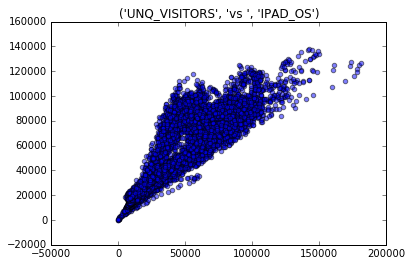

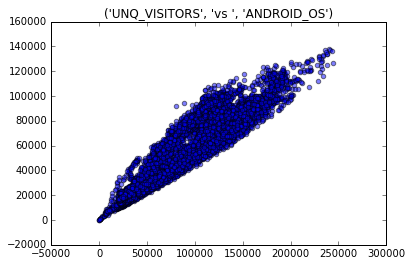

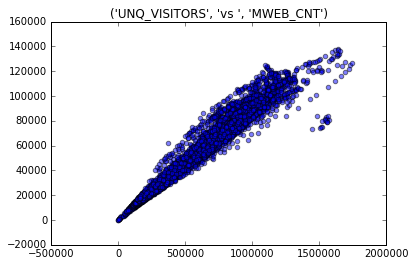

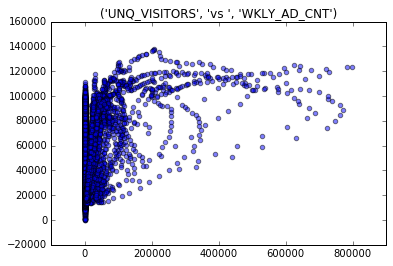

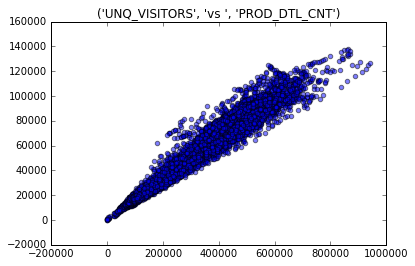

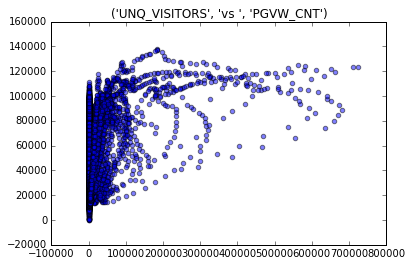

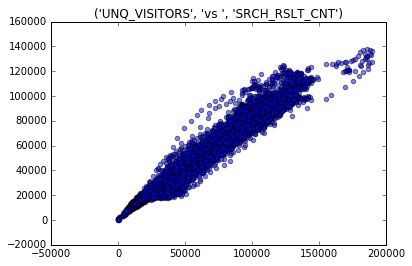

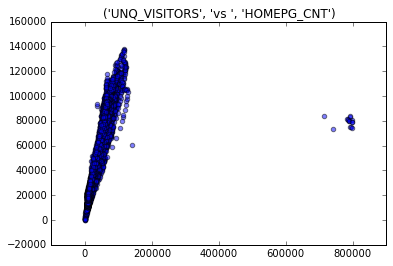

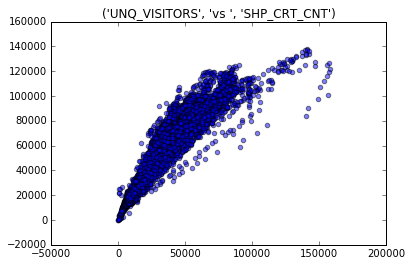

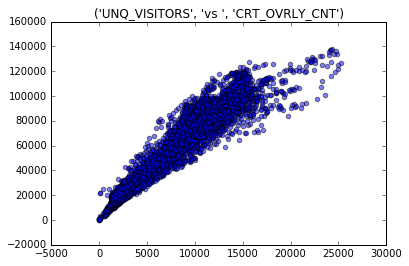

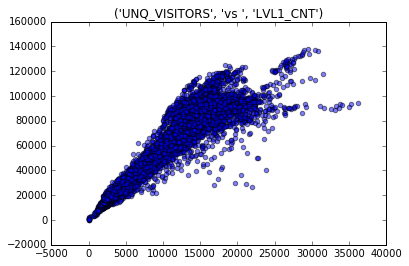

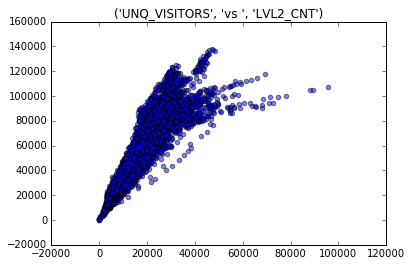

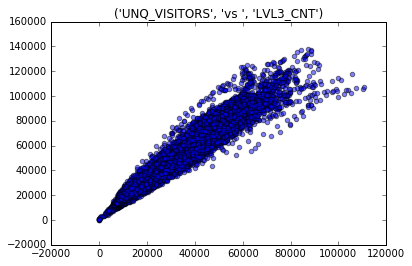

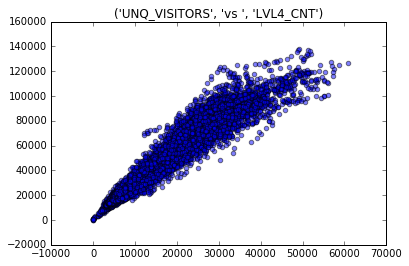

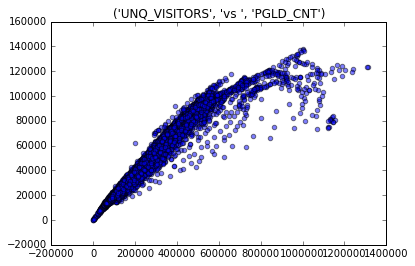

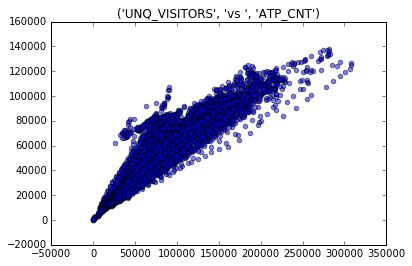

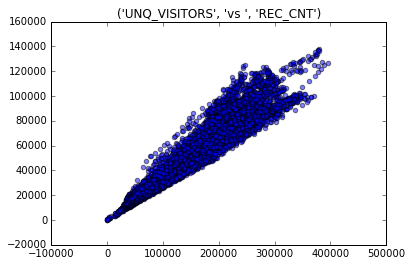

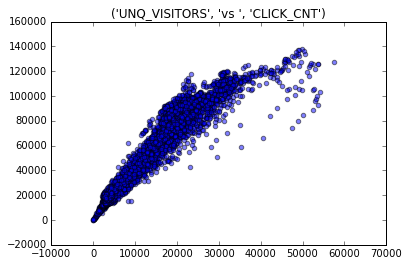

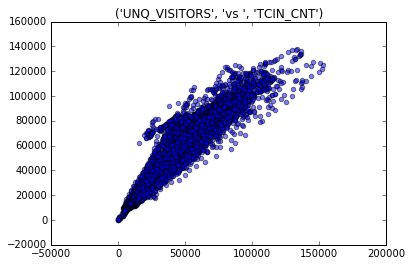

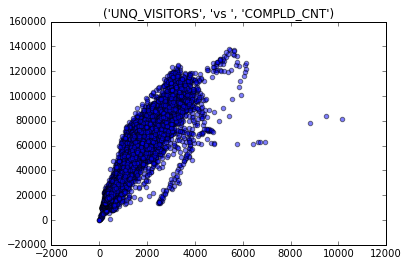

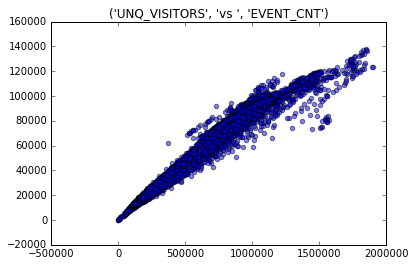

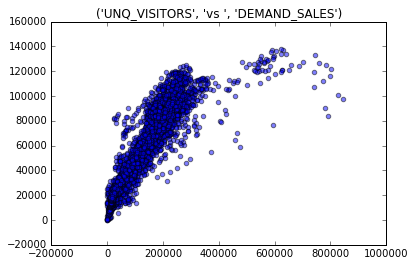

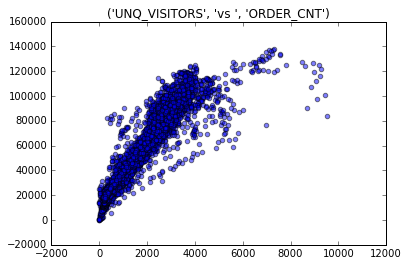

In [7]:
cols = df.columns.tolist()
cols = ['unq_visitors']  + [col for col in df if col != 'unq_visitors']
df_eda = df[cols]
l1 = len(cols)

y = df_eda.ix[:,0]

for z in range(5,l1):
    x = df_eda.ix[:,z]
    plt.scatter(x, y, alpha=0.5)
    ttl = df_eda.columns[0].upper(), 'vs ', df_eda.columns[z].upper()
    plt.title(ttl)
    plt.show()

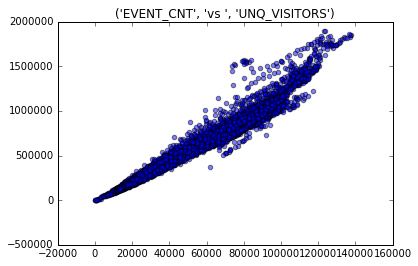

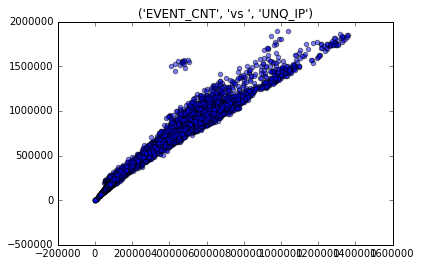

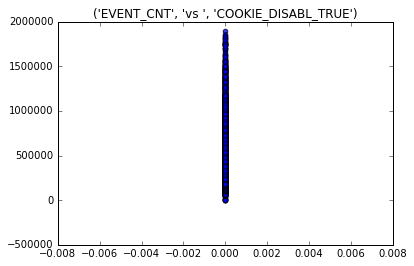

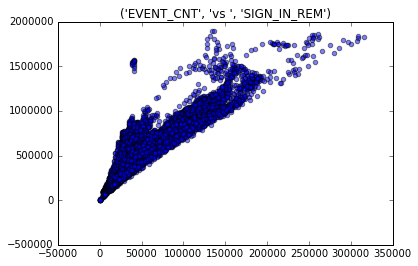

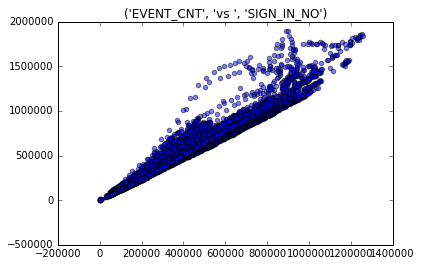

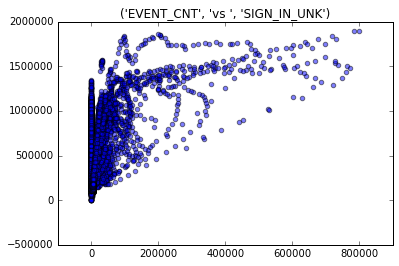

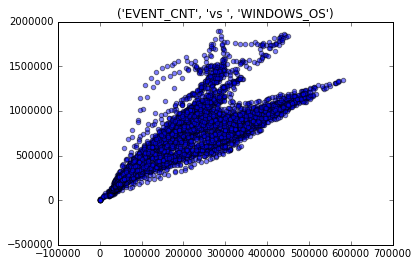

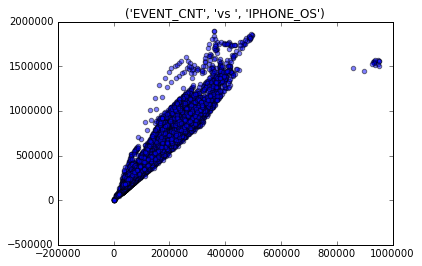

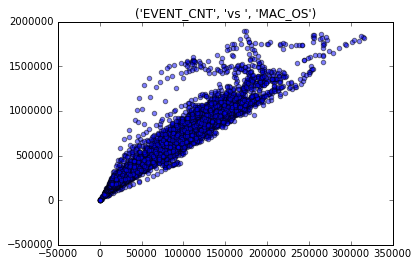

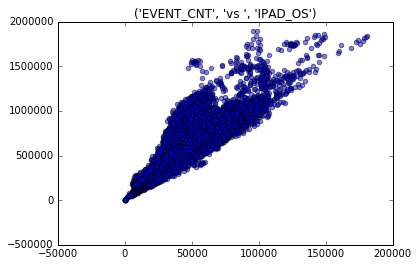

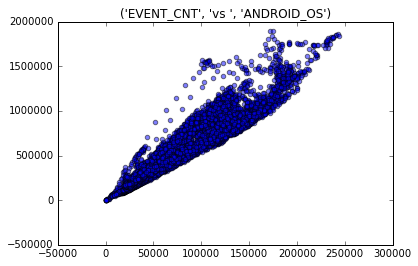

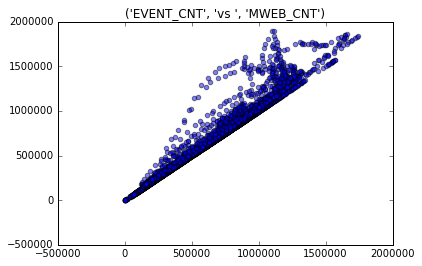

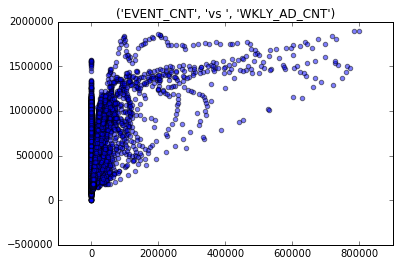

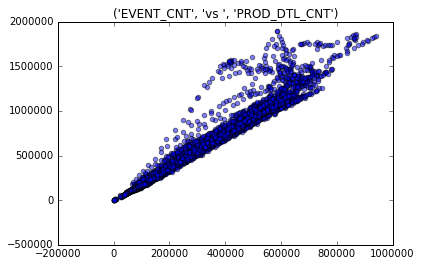

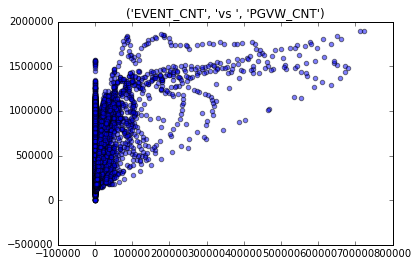

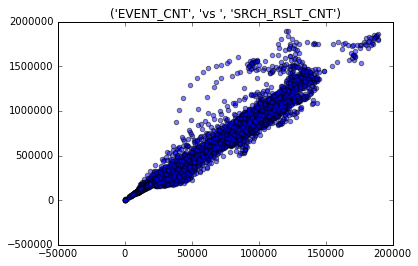

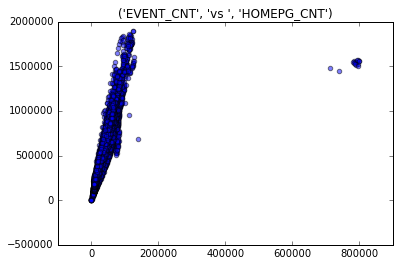

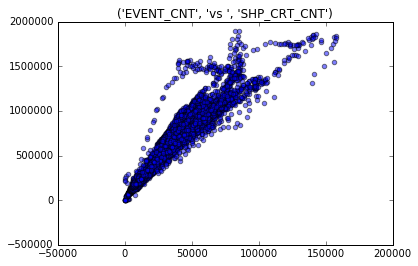

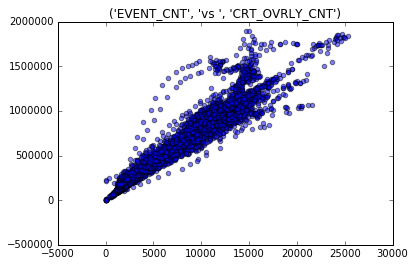

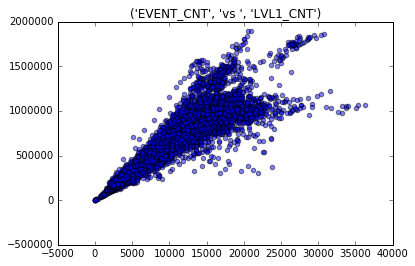

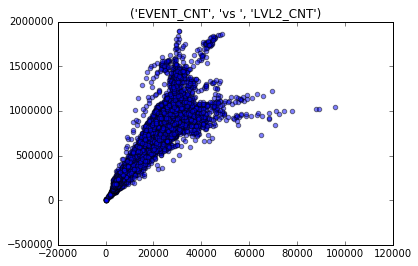

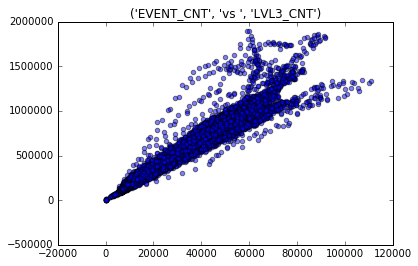

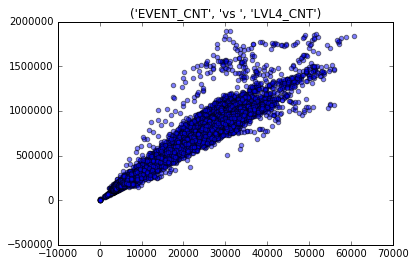

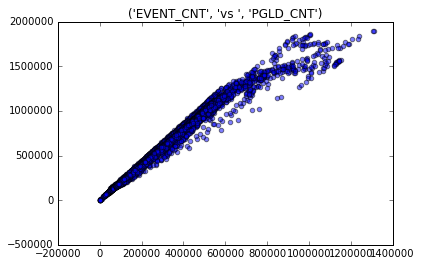

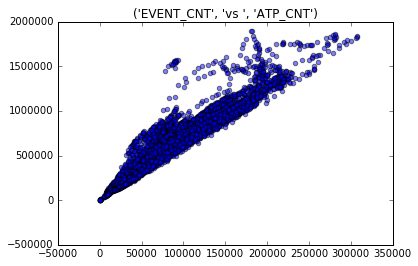

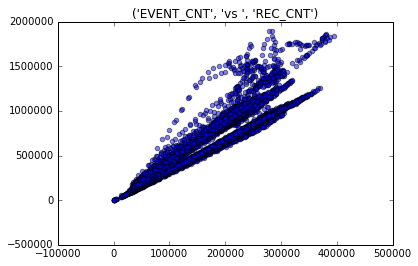

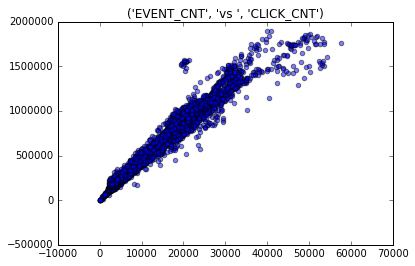

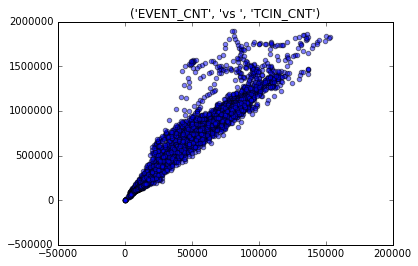

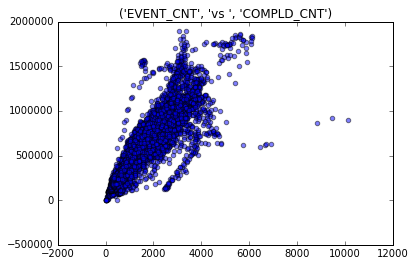

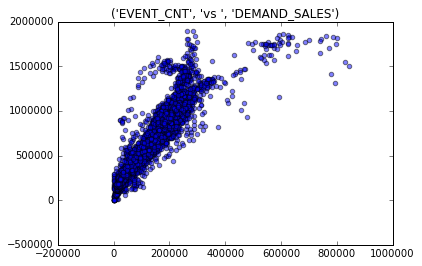

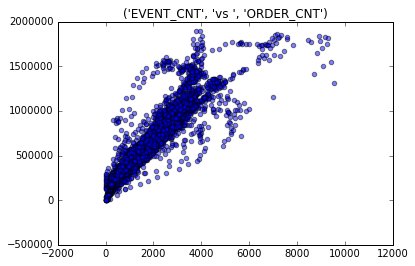

In [8]:
cols = df.columns.tolist()
cols = ['event_cnt']  + [col for col in df if col != 'event_cnt']
df_eda = df[cols]
l1 = len(cols)

y = df_eda.ix[:,0]

for z in range(5,l1):
    x = df_eda.ix[:,z]
    plt.scatter(x, y, alpha=0.5)
    ttl = df_eda.columns[0].upper(), 'vs ', df_eda.columns[z].upper()
    plt.title(ttl)
    plt.show()

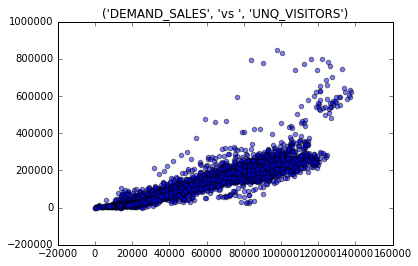

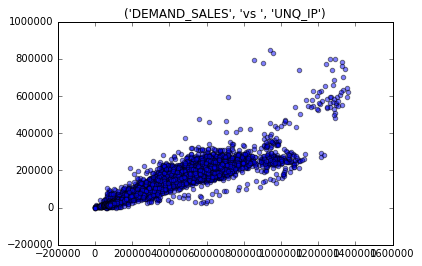

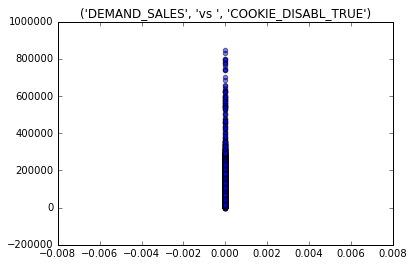

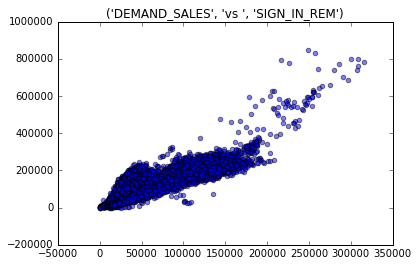

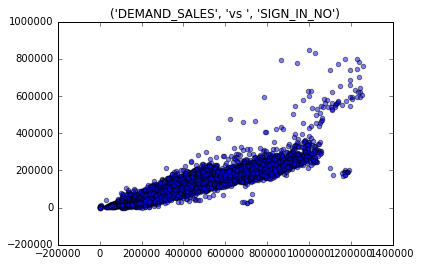

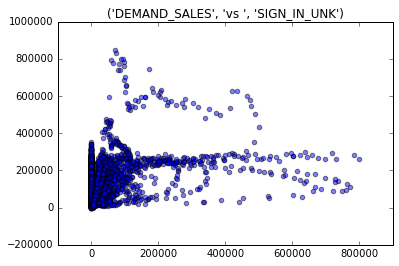

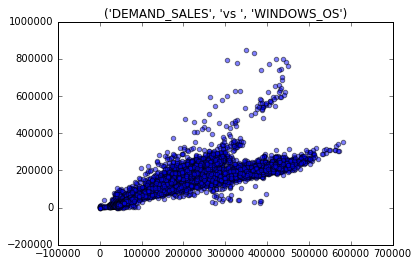

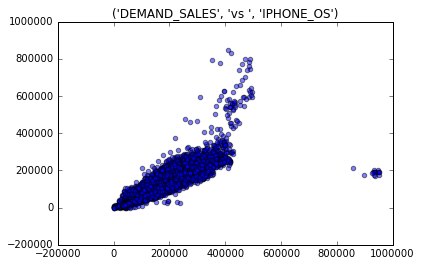

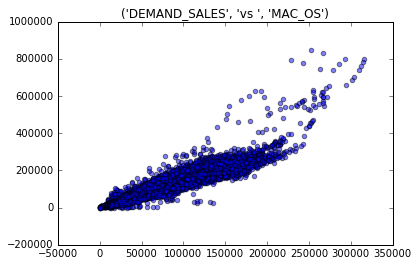

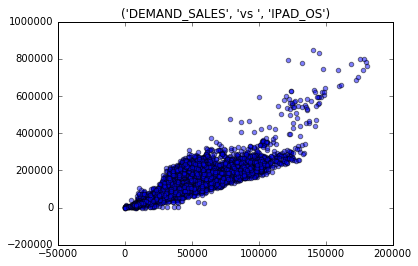

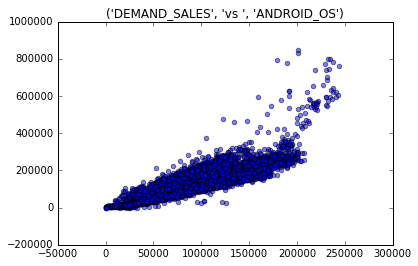

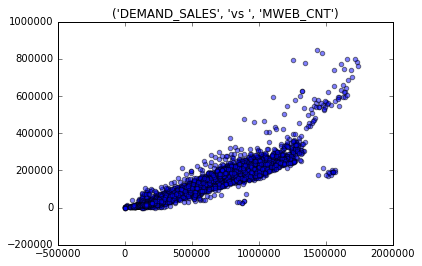

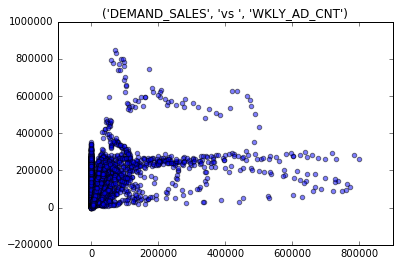

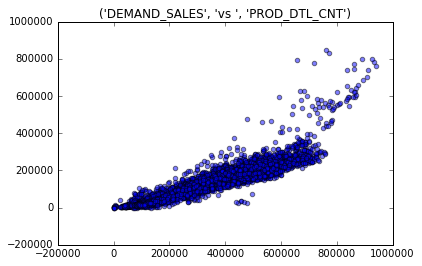

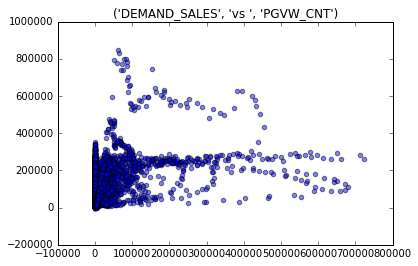

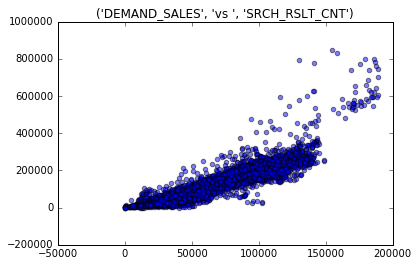

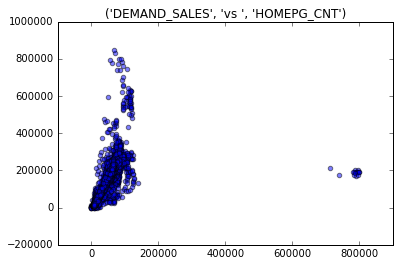

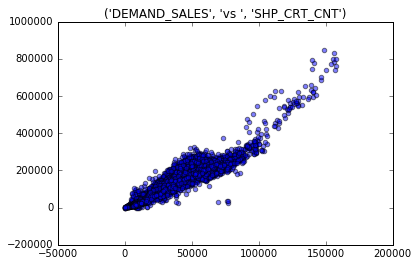

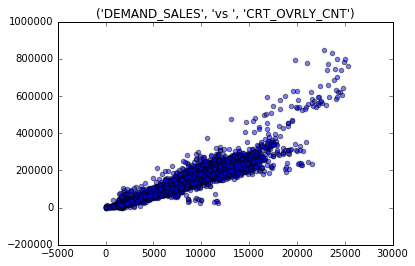

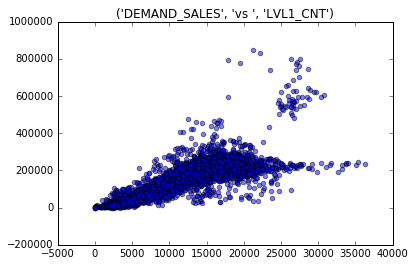

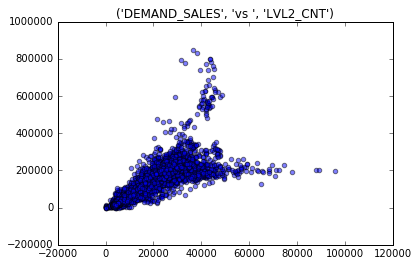

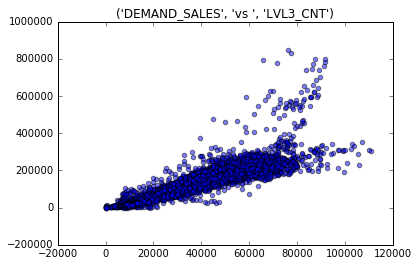

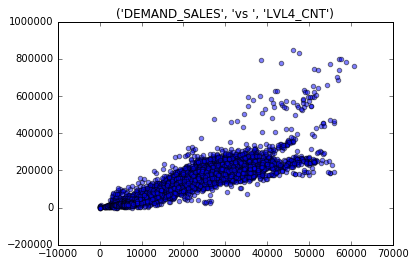

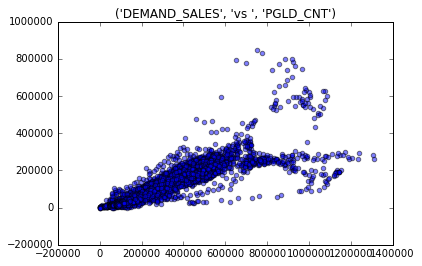

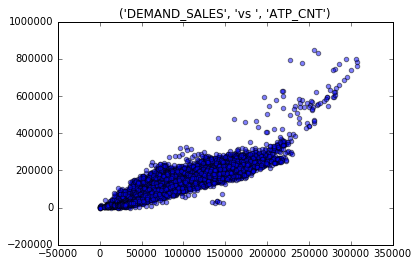

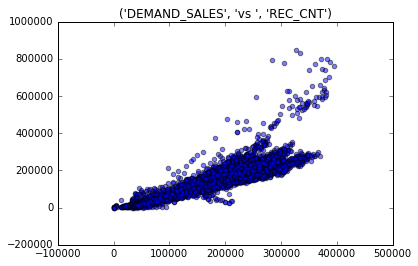

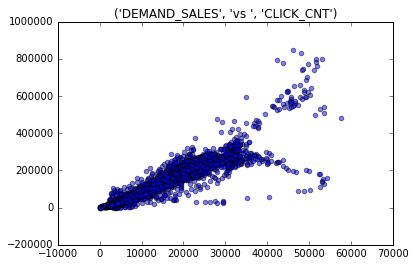

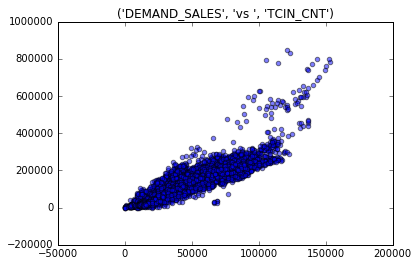

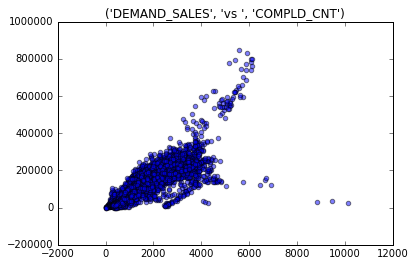

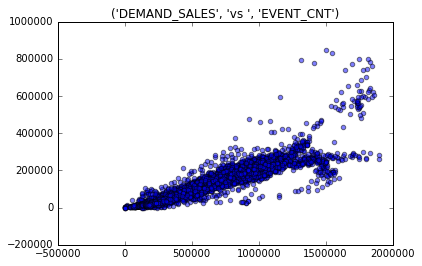

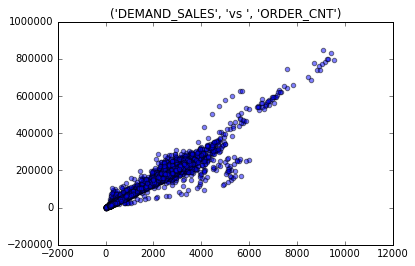

In [9]:
cols = df.columns.tolist()
cols = ['demand_sales']  + [col for col in df if col != 'demand_sales']
df_eda = df[cols]
l1 = len(cols)

y = df_eda.ix[:,0]

for z in range(5,l1):
    x = df_eda.ix[:,z]
    plt.scatter(x, y, alpha=0.5)
    ttl = df_eda.columns[0].upper(), 'vs ', df_eda.columns[z].upper()
    plt.title(ttl)
    plt.show()

In [10]:
df_eda = df_eda.drop('event_ts', axis=1)
df_eda = df_eda.drop('event_dt', axis=1)

In [11]:
df_eda.corr()

demand_sales  event_hr  event_min  unq_visitors    unq_ip  \
demand_sales            1.000000  0.296328   0.007934      0.895850  0.906330   
event_hr                0.296328  1.000000   0.000000      0.374009  0.301235   
event_min               0.007934  0.000000   1.000000      0.010246  0.011186   
unq_visitors            0.895850  0.374009   0.010246      1.000000  0.959481   
unq_ip                  0.906330  0.301235   0.011186      0.959481  1.000000   
cookie_disabl_true           NaN       NaN        NaN           NaN       NaN   
sign_in_rem             0.867806  0.214143   0.009573      0.881707  0.925716   
sign_in_no              0.897264  0.298103   0.014539      0.959572  0.945537   
sign_in_unk             0.291988  0.119874   0.001720      0.350533  0.450706   
windows_os              0.794304  0.504104   0.014267      0.860963  0.787671   
iphone_os               0.845449  0.180328   0.013411      0.888740  0.877225   
mac_os                  0.917420  0.210994   0.008587      0.939879  0.934358   
ipad_os                 0.836747  0.029272   0.012598      0.840344  0.854475   
android_os              0.870196  0.159254   0.015850      0.924353  0.920706   
mweb_cnt                0.924222  0.302400   0.014317      0.978074  0.952401   
wkly_ad_cnt             0.285264  0.112985   0.001280      0.339334  0.455029   
prod_dtl_cnt            0.918215  0.268658   0.015430      0.972989  0.957643   
pgvw_cnt                0.284655  0.113712   0.001300      0.338008  0.453046   
srch_rslt_cnt           0.908819  0.297382   0.014715      0.975934  0.944059   
homepg_cnt              0.552131  0.303432   0.008318      0.606950  0.560015   
shp_crt_cnt             0.927973  0.274893   0.008629      0.915863  0.935558   
crt_ovrly_cnt           0.938535  0.320212   0.010965      0.954928  0.928100   
lvl1_cnt                0.852428  0.386525   0.011724      0.921118  0.873474   
lvl2_cnt                0.822242  0.326061   0.012239      0.891375  0.827934   
lvl3_cnt                0.889534  0.280393   0.014381      0.959811  0.916433   
lvl4_cnt                0.876598  0.233901   0.014472      0.948723  0.929979   
pgld_cnt                0.865824  0.303892   0.012141      0.937543  0.952781   
atp_cnt                 0.886803  0.244497   0.014945      0.930956  0.954775   
rec_cnt                 0.890812  0.317118   0.013280      0.942824  0.882591   
click_cnt               0.927110  0.308222   0.009596      0.946796  0.954590   
tcin_cnt                0.898689  0.226996   0.016675      0.942557  0.959037   
compld_cnt              0.853240  0.384621   0.007294      0.874916  0.858033   
event_cnt               0.913618  0.304610   0.013592      0.975828  0.975100   
order_cnt               0.967909  0.329659   0.009491      0.923279  0.913514   

                    cookie_disabl_true  sign_in_rem  sign_in_no  sign_in_unk  \
demand_sales                       NaN     0.867806    0.897264     0.291988   
event_hr                           NaN     0.214143    0.298103     0.119874   
event_min                          NaN     0.009573    0.014539     0.001720   
unq_visitors                       NaN     0.881707    0.959572     0.350533   
unq_ip                             NaN     0.925716    0.945537     0.450706   
cookie_disabl_true                 NaN          NaN         NaN          NaN   
sign_in_rem                        NaN     1.000000    0.924929     0.332424   
sign_in_no                         NaN     0.924929    1.000000     0.261288   
sign_in_unk                        NaN     0.332424    0.261288     1.000000   
windows_os                         NaN     0.764538    0.837036     0.158569   
iphone_os                          NaN     0.796705    0.914648     0.278347   
mac_os                             NaN     0.890643    0.959263     0.251490   
ipad_os                            NaN     0.769269    0.845606     0.308097   
android_os                         NaN     0.853137    0.923159 

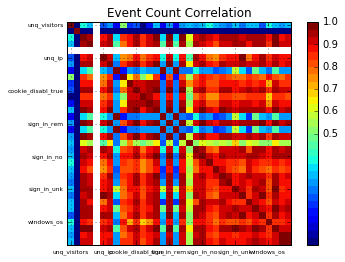

In [12]:
def correlation_matrix(df_dataset):
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df_dataset.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Event Count Correlation')
    labels=df_dataset.columns[3:].tolist()
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax, ticks=[.50,.60,.70,.80,.90,1])
    plt.show()

correlation_matrix(df)

## 3.  ETL <a name="3"></a>
[Back to Table of Contents](#TOC)

## 4.  Feature Engineering <a name="4"></a>
[Back to Table of Contents](#TOC)

In [ ]:
cols = df.columns.tolist()
cols = ['event_ts']  + [col for col in df if col != 'event_ts']
df = df[cols]
df['os_mac_pct'] = df['mac_os']/df['event_cnt']
df['os_ipad_pct'] = df['ipad_os']/df['event_cnt']
df['os_windows_pct'] = df['windows_os']/df['event_cnt']
df['os_android_pct'] = df['android_os']/df['event_cnt']
df['os_iphone_pct'] = df['iphone_os']/df['event_cnt']
df['evnt_unq_ratio'] = df['event_cnt']/df['unq_visitors']
df['mweb_pct'] = df['mweb_cnt']/df['event_cnt']
df['wkly_ad_pct'] = df['wkly_ad_cnt']/df['event_cnt']
df['prod_dtl_pct'] = df['prod_dtl_cnt']/df['event_cnt']
df['pgvw_pct'] = df['pgvw_cnt']/df['event_cnt']
df['srch_pct'] = df['srch_rslt_cnt']/df['event_cnt']
df['homepg_pct'] = df['homepg_cnt']/df['event_cnt']
df['shp_crt_pct'] = df['shp_crt_cnt']/df['event_cnt']
df['crt_ovrly_pct'] = df['crt_ovrly_cnt']/df['event_cnt']
df['order_pct'] = df['order_cnt']/df['event_cnt']
df = df.drop('cookie_disabl_true', axis=1)
df = df.drop('wkly_ad_cnt',axis=1)
df = df.dropna()
df['dayofwk'] = df['event_dt'].dt.dayofweek
cols = df.columns.tolist()
cols = ['event_cnt']  + [col for col in df if col != 'event_cnt']
df = df[cols]

## 5.  Modeling, Evaluation & Tuning <a name="5"></a>
[Back to Table of Contents](#TOC)

## 6.  Results / Systems Used <a name="6"></a>
[Back to Table of Contents](#TOC)

## 7.  Next Steps <a name="7"></a>
[Back to Table of Contents](#TOC)

## 8.  Resources / References <a name="8"></a>
[Back to Table of Contents](#TOC)

## 9.  Appendix <a name="9"></a>
[Back to Table of Contents](#TOC)